<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Глобальные-параметры" data-toc-modified-id="Глобальные-параметры-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Глобальные параметры</a></span></li><li><span><a href="#Библиотеки-для-работы" data-toc-modified-id="Библиотеки-для-работы-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Библиотеки для работы</a></span></li><li><span><a href="#Загрузка-датасета" data-toc-modified-id="Загрузка-датасета-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Загрузка датасета</a></span></li><li><span><a href="#Оценка-баланса-классов-в-таргете" data-toc-modified-id="Оценка-баланса-классов-в-таргете-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Оценка баланса классов в таргете</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Проверка-на-дубликаты-и-пропуски-в-лемматизированном-датасете" data-toc-modified-id="Проверка-на-дубликаты-и-пропуски-в-лемматизированном-датасете-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Проверка на дубликаты и пропуски в лемматизированном датасете</a></span></li><li><span><a href="#Итоговый-датасет-перед-обучением-моделей" data-toc-modified-id="Итоговый-датасет-перед-обучением-моделей-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Итоговый датасет перед обучением моделей</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#CatBoost-+-TF-IDF-pipeline" data-toc-modified-id="CatBoost-+-TF-IDF-pipeline-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>CatBoost + TF-IDF pipeline</a></span></li><li><span><a href="#BERT-Embedding" data-toc-modified-id="BERT-Embedding-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>BERT Embedding</a></span></li><li><span><a href="#CatBoost-+-BERT" data-toc-modified-id="CatBoost-+-BERT-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoost + BERT</a></span></li><li><span><a href="#Сравнение-результатов-обучения" data-toc-modified-id="Сравнение-результатов-обучения-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Сравнение результатов обучения</a></span></li></ul></li><li><span><a href="#Проверка-на-тесте" data-toc-modified-id="Проверка-на-тесте-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка на тесте</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

In [1]:
!python --version

Python 3.11.3


# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Глобальные параметры

In [2]:
SEED = 12345 #random_state
ITERATIONS = 5 # iterations

### Библиотеки для работы

- `catboost` - основной классификатор с возможностью запуска на GPU, что выгодно для больших матриц
- `nltk` - работа с лемматизацией и словарем
- `numpy`, `pandas`, `torch` - датасеты, массивы, тензоры
- `re` - регулярные выражения
- `sklearn` - работа с выборками и моделями МО
- `matplotlib`, `seaborn` - графики
- `transformers` - работа с моделью BERT
- `tqdm` - таймер циклов

In [3]:
from catboost import CatBoostClassifier
import gc
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
import spacy
import torch
import transformers
from tqdm import tqdm

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

### Загрузка датасета

Грузим с сервера данные:

In [5]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0]).reset_index(drop=True)
#df = df.sample(2000, random_state=SEED).reset_index(drop=True)

И смотрим на формат строк:

In [6]:
df.head(3)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


### Оценка баланса классов в таргете

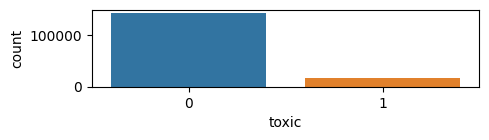

In [7]:
plt.figure(figsize=(5,1))
sns.countplot(data=df,
              x='toxic');

In [8]:
df['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

Задаем параметр баланса классов для CatBoostClassifier:

In [9]:
SCALE = 1/(df['toxic'].value_counts(normalize=True)[1])
SCALE

9.841344371679229

### Лемматизация

Инициируем лемматизацию `spaCy`:

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [11]:
def lemmatize(text):
    # лемматизируем каждый из них
    lemmatized_tokens = ' '.join([token.lemma_ for token in nlp(text)])
    return lemmatized_tokens

In [12]:
def clear_text(text):
    # оставляем только латинницу
    text = text.lower()
    text = ' '.join(re.sub(r'[^a-z]', ' ', text).split()) 
    #text = ' '.join(re.sub(r'[^a-zA-Z]', ' ', text).split()) 
    # убираем артикли
    text = text.replace(' the ', ' ') 
    text = text.replace('the ', '') 
    text = text.replace(' a ', ' ' )
    text = text.replace('a ', '')
    # убираем повторные пробелы и пробелы в начале и конце строк
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

Очищаем текст от знаков препинания, артиклей и пробелов:

In [13]:
df['clear'] = [clear_text(text) for text in tqdm(df['text'])]

100%|██████████| 159292/159292 [00:04<00:00, 35486.19it/s]


Проводим лемматизацию форм:

In [14]:
%%time
try:
    df = pd.read_csv('./datasets/lemm_text.csv')
except:
    df['lemm'] = [lemmatize(text) for text in tqdm(df['clear'])]
    df.to_csv('./datasets/lemm_text.csv', index=False)

CPU times: total: 406 ms
Wall time: 911 ms


In [15]:
df = df[['lemm', 'text', 'toxic']]

### Проверка на дубликаты и пропуски в лемматизированном датасете

In [16]:
# полные дубликаты
print(df.duplicated().sum())
df = df.drop_duplicates()

0


In [17]:
# пропуски
print(df.isna().sum())
df = df.dropna()

lemm     11
text      0
toxic     0
dtype: int64


### Итоговый датасет перед обучением моделей

In [18]:
df.head(3)

,lemm,text,toxic
0,explanation why edit make under my username ha...,Explanation\nWhy the edits made under my usern...,0
1,d aww he match this background colour I m seem...,D'aww! He matches this background colour I'm s...,0
2,hey man I m really not try to edit war it s ju...,"Hey man, I'm really not trying to edit war. It...",0


## Обучение

Разбивка на трейн и тест:

In [19]:
train, test = train_test_split(df, test_size=0.25, random_state=SEED)

Таргетные столбцы для моделей:

In [20]:
x_train = train['lemm']
x_test = test['lemm']
y_train = train['toxic']
y_test = test['toxic']

### CatBoost + TF-IDF pipeline

In [21]:
# фильтр стоп слов
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Подготовим пайплайн с фичами `TF-IDF`:

In [22]:
cb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('cb', CatBoostClassifier(random_state=SEED,
                              task_type='GPU',
                              scale_pos_weight=SCALE,
                              verbose=500,
                              iterations=1000,
                              eval_metric='F1'))
])

Задаем сетку параметров и тип поиска:

In [23]:
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'cb__max_depth': [2, 4, 8],
    'cb__l2_leaf_reg': [1, 3]
}

In [24]:
cb_rs = RandomizedSearchCV(cb_pipe,
                           param_distributions=param_grid,
                           scoring='f1',
                           cv=4,
                           n_iter=ITERATIONS,
                           random_state=SEED,
                           verbose=3)

In [25]:
%%time
cb_rs.fit(x_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
0:	learn: 0.6624323	total: 89.3ms	remaining: 1m 29s
500:	learn: 0.9675995	total: 35.8s	remaining: 35.7s
999:	learn: 0.9848038	total: 1m 10s	remaining: 0us
[CV 1/4] END cb__l2_leaf_reg=1, cb__learning_rate=0.1, cb__max_depth=8, tfidf__max_features=10000, tfidf__ngram_range=(1, 1);, score=0.757 total time= 1.3min
0:	learn: 0.6973446	total: 175ms	remaining: 2m 55s
500:	learn: 0.9684383	total: 32.3s	remaining: 32.2s
999:	learn: 0.9851110	total: 1m 3s	remaining: 0us
[CV 2/4] END cb__l2_leaf_reg=1, cb__learning_rate=0.1, cb__max_depth=8, tfidf__max_features=10000, tfidf__ngram_range=(1, 1);, score=0.756 total time= 1.2min
0:	learn: 0.6619302	total: 166ms	remaining: 2m 45s
500:	learn: 0.9687838	total: 32.4s	remaining: 32.3s
999:	learn: 0.9847969	total: 1m 3s	remaining: 0us
[CV 3/4] END cb__l2_leaf_reg=1, cb__learning_rate=0.1, cb__max_depth=8, tfidf__max_features=10000, tfidf__ngram_range=(1, 1);, score=0.754 total time= 1.2min
0:	le

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('cb',
                                              <catboost.core.CatBoostClassifier object at 0x000001ADD3BC4A50>)]),
                   n_iter=5,
                   param_distributions={'cb__l2_leaf_reg': [1, 3],
                                        'cb__learning_rate': [0.01, 0.05, 0.1,
                                                              0.2],
                                        'cb__max_depth': [2, 4, 8],
                                        'tfidf__max_features': [5000, 10000],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)]},
                   random_state=12345, scoring='f1', verbose=3)

In [26]:
cb_rs.best_params_

{'tfidf__ngram_range': (1, 1),
 'tfidf__max_features': 10000,
 'cb__max_depth': 8,
 'cb__learning_rate': 0.2,
 'cb__l2_leaf_reg': 1}

In [27]:
cb_rs.best_score_

0.7739454140760829

In [28]:
print(f'Метрика F1 для кросс-валидации CatBoost + TF-IDF', cb_rs.best_score_)

Метрика F1 для кросс-валидации CatBoost + TF-IDF 0.7739454140760829


### BERT Embedding

Будем использовать предобученную модель `unitary/toxic-bert`:

In [29]:
model_name = 'unitary/toxic-bert'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Готовим список инпутов и attention_masks для каждого предложения столбца `lemm` в датафрейме df. Берем сырой текст без предобработки. На выходе два тензора для передачи в модель BERT:
- Ограничим длину строки max_length = 256
- Добавляем специальные токены начала и конца предложения
- Выполняем паддинг и возвращаем данные в виде тензоров `PyTorch`

In [30]:
%%time
input_ids = []
attention_masks = []

for sentence in tqdm(df['text']):
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=256,
        truncation=True,
        pad_to_max_length='longest',
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
input_ids.shape, attention_masks.shape

  0%|          | 0/159281 [00:00<?, ?it/s]c:\ProgramData\anaconda3\envs\py311\Lib\site-packages\transformers\tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 159281/159281 [01:11<00:00, 2231.90it/s]


CPU times: total: 31 s
Wall time: 1min 11s


(torch.Size([159281, 256]), torch.Size([159281, 256]))

Собираем эмбеддинги из тензора `PyTorch` в датафрейм features:

In [31]:
%%time
batch_size = 1500
embeddings = []
with torch.no_grad():
    for i in tqdm(range(0, len(df), batch_size)):
        input_ids_batch = input_ids[i:i+batch_size].to(device)
        attention_masks_batch = attention_masks[i:i+batch_size].to(device)
        embeddings_batch = model.to(device)(input_ids_batch, attention_mask=attention_masks_batch)
        embeddings.append(embeddings_batch[0][:,0,:].cpu().numpy())
        del input_ids_batch
        del attention_masks_batch
        del embeddings_batch
features = np.concatenate(embeddings)
# clear gpu memory and embeddings cache
torch.cuda.empty_cache()
gc.collect()
del embeddings

100%|██████████| 107/107 [07:28<00:00,  4.19s/it]


CPU times: total: 4min 9s
Wall time: 7min 28s


Готовим выборки фич на основе BERT:

In [32]:
x_train_bert, x_test_bert = train_test_split(features, test_size=0.25, random_state=SEED)
x_train_bert.shape, x_test_bert.shape

((119460, 768), (39821, 768))

### CatBoost + BERT

Повторяем рандом серч с фичами BERT:

In [33]:
cbc_bert = CatBoostClassifier(random_state=SEED,
                         task_type='GPU',
                         scale_pos_weight=SCALE,
                         verbose=500,
                         iterations=1000,
                         eval_metric='F1')

In [34]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [2, 4, 8],
              'l2_leaf_reg': [1, 3]
              }

In [35]:
%%time
cbc_bert_rs = cbc_bert.randomized_search(parameters,
                                         X=x_train_bert,
                                         y=y_train,
                                         n_iter=ITERATIONS,
                                         cv=4,
                                         partition_random_seed=SEED,
                                         verbose=1)

0:	learn: 0.9808045	test: 0.9806757	best: 0.9806757 (0)	total: 33.6ms	remaining: 33.6s
500:	learn: 0.9910606	test: 0.9829804	best: 0.9838235 (92)	total: 18s	remaining: 17.9s
999:	learn: 0.9922121	test: 0.9831425	best: 0.9838235 (92)	total: 35.8s	remaining: 0us
bestTest = 0.9838234613
bestIteration = 92
0:	loss: 0.9838235	best: 0.9838235 (0)	total: 36.6s	remaining: 2m 26s
0:	learn: 0.9830986	test: 0.9810707	best: 0.9810707 (0)	total: 180ms	remaining: 2m 59s
500:	learn: 0.9889259	test: 0.9834237	best: 0.9834686 (366)	total: 1m 33s	remaining: 1m 33s
999:	learn: 0.9918848	test: 0.9827641	best: 0.9836960 (522)	total: 3m 9s	remaining: 0us
bestTest = 0.9836959897
bestIteration = 522
1:	loss: 0.9836960	best: 0.9838235 (0)	total: 3m 45s	remaining: 5m 38s
0:	learn: 0.9830986	test: 0.9810707	best: 0.9810707 (0)	total: 191ms	remaining: 3m 11s
500:	learn: 0.9945154	test: 0.9819946	best: 0.9835377 (20)	total: 1m 36s	remaining: 1m 35s
999:	learn: 0.9957227	test: 0.9802992	best: 0.9835377 (20)	total: 

In [36]:
cbc_bert_rs['params']

{'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.05}

In [37]:
print(f'Метрика F1 для кросс-валидации CatBoostClassifier+BERT', max(cbc_bert_rs['cv_results']['test-F1-mean']))

Метрика F1 для кросс-валидации CatBoostClassifier+BERT 0.9832038647250886


### Сравнение результатов обучения

In [38]:
result = pd.DataFrame({'F1-score' : [cb_rs.best_score_, max(cbc_bert_rs['cv_results']['test-F1-mean'])]},
                                     index=['CB+TFIDF', 'CB+BERT'])
result

,F1-score
CB+TFIDF,0.773945
CB+BERT,0.983204


С фичами BERT валидационный скор выше.

## Проверка на тесте

Лучшей моделью по валидации выбрана CatBoostClassifier + Bert Embedding:

In [39]:
cbc_bert = CatBoostClassifier(iterations=1000,
                              random_state=SEED,
                              task_type='GPU',
                              scale_pos_weight=SCALE,
                              verbose=False,
                              eval_metric='F1',
                              **cbc_bert_rs['params'])

In [40]:
cbc_bert.fit(x_train_bert, y_train, eval_set=(x_test_bert, y_test), verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9811808	test: 0.9793088	best: 0.9793088 (0)	total: 7.45ms	remaining: 7.44s
200:	learn: 0.9869334	test: 0.9809753	best: 0.9821268 (9)	total: 1.27s	remaining: 5.04s
400:	learn: 0.9901533	test: 0.9808246	best: 0.9821268 (9)	total: 2.54s	remaining: 3.79s
600:	learn: 0.9923747	test: 0.9810953	best: 0.9821268 (9)	total: 3.79s	remaining: 2.52s
800:	learn: 0.9934723	test: 0.9807795	best: 0.9821268 (9)	total: 5.05s	remaining: 1.25s
999:	learn: 0.9941021	test: 0.9799980	best: 0.9821268 (9)	total: 6.3s	remaining: 0us
bestTest = 0.9821267821
bestIteration = 9
Shrink model to first 10 iterations.


In [41]:
cbc_bert.best_score_['validation']['F1']

0.9821267820768207

**Модель CatBoost + BERT прошла проверку на F1 > 0.75**

## Выводы

**Выводы** 
- Протестированы два подхода к созданию фич для NLP: TF-IDF, BERT эмбеддинг
- Обучены модели с применением рандом-серча параметров и кросс-валидации
- Лучшей моделью показала себя CatBoostClassifier + Bert Embedding с тестовым скором 0.88